# Graph Overview feature

## Shortest Path Kernel

In [21]:
import grakel
from grakel.kernels import GraphletSampling, WeisfeilerLehman
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import networkx as nx
from grakel.utils import graph_from_networkx
from grakel import GraphKernel

In [22]:
G1 = nx.Graph([(0, 1), (1, 2), (1, 3), (2, 3), (2, 4)])
nx.set_node_attributes(G1, {0:'a', 1:'b', 2:'c', 3:'d', 4:'e'}, 'label')

G2 = nx.Graph([(0, 1), (1, 2), (2, 3), (0, 3), (1, 4)])
nx.set_node_attributes(G2, {0:'a', 1:'a', 2:'b', 3:'d', 4:'e'}, 'label')

nx_graphs = [G1, G2]

graphs = graph_from_networkx(nx_graphs, node_labels_tag='label')

gk = GraphKernel(kernel=[{"name": "shortest_path"}], normalize=True)
# Return similarity scores among pairs of graphs in nx_graphs
similarity_arr = gk.fit_transform(graphs)

# Define index of 2 graphs in the array of similarity scores
G1_index = 0
G2_index = 1

print(f"Similarity between 2 graphs: {similarity_arr[G1_index][G2_index]}")

Similarity between 2 graphs: 0.38138503569823695


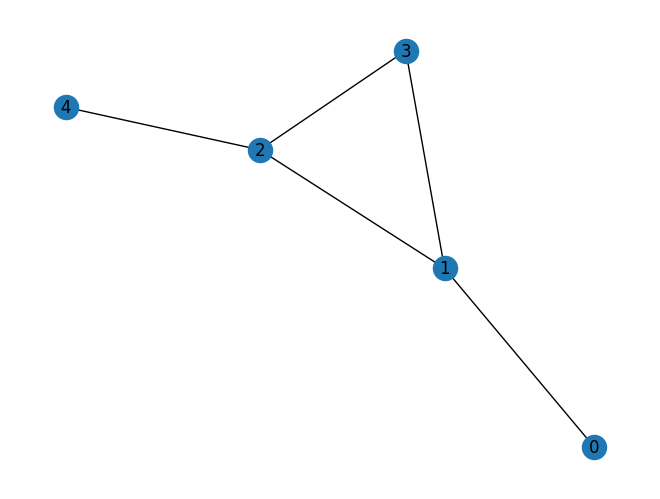

In [23]:
nx.draw(G1, with_labels = True)

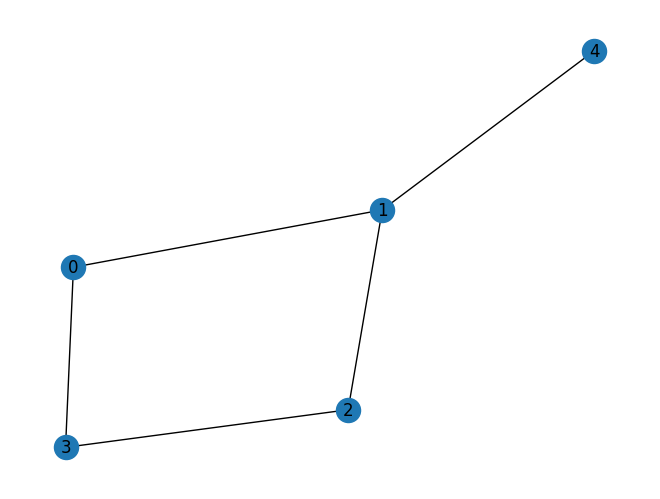

In [24]:
nx.draw(G2, with_labels = True)

## Random walk kernel

In [25]:
G1 = nx.Graph([(0, 1), (1, 2), (1, 3), (2, 3), (2, 4)])
nx.set_node_attributes(G1, {0:'a', 1:'b', 2:'c', 3:'d', 4:'e'}, 'label')

G2 = nx.Graph([(0, 1), (1, 2), (2, 3), (0, 3), (1, 4)])
nx.set_node_attributes(G2, {0:'a', 1:'a', 2:'b', 3:'d', 4:'e'}, 'label')

nx_graphs = [G1, G2]

graphs = graph_from_networkx(nx_graphs, node_labels_tag='label')

gk = GraphKernel(kernel=[{"name": "random_walk"}], normalize=True)
# Return similarity scores among pairs of graphs in nx_graphs
similarity_arr = gk.fit_transform(graphs)

# Define index of 2 graphs in the array of similarity scores
G1_index = 0
G2_index = 1

print(f"Similarity between 2 graphs: {similarity_arr[G1_index][G2_index]}")

Similarity between 2 graphs: 0.9966158911007547


## Weisleifer - Lehman

In [26]:
G1 = nx.Graph()
G1.add_edges_from(
    [
        ("red", "orange"),
        ("red", "yellow"),
        ("red", "green"),
        ("orange", "yellow"),
        ("yellow", "blue"),
        ("green", "blue"),
    ]
)

G2 = nx.Graph()
G2.add_edges_from(
    [
        ("yellow", "red"),
        ("yellow", "orange"),
        ("yellow", "blue"),
        ("red", "orange"),
        ("red", "green"),
        ("green", "blue"),
    ]
)

g1_hash = nx.weisfeiler_lehman_graph_hash(G1)
g2_hash = nx.weisfeiler_lehman_graph_hash(G2)

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: 8c44c442a25e00dfae4e1647b2faf79f
Second graph hash: 8c44c442a25e00dfae4e1647b2faf79f
Checking graph isomorphic: True


## Simrank

In [27]:
G = nx.Graph([('A', 'C'), ('A', 'D'), ('A', 'E'), ('B', 'C'), ('B', 'D'), ('B', 'F')])

print(f"SimRank similarity between A and B: {nx.simrank_similarity(G, source='A', target='B')}")

print(f"SimRank similarity between C and D: {nx.simrank_similarity(G, source='C', target='D')}")

SimRank similarity between A and B: 0.7343004169068217
SimRank similarity between C and D: 0.7804009111226942


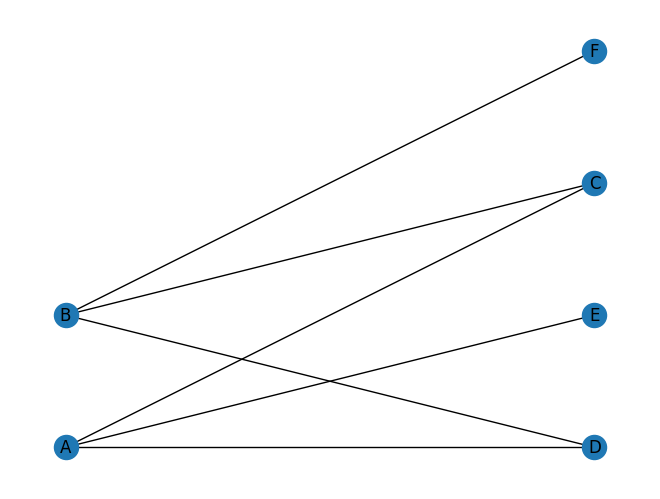

In [28]:
X, Y = nx.bipartite.sets(G)
pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update((n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(G, pos=pos, with_labels = True)
plt.show()

## From Images to Graphs:
We will now transform the digits into graphs and perform graph classification.

We will transform each image into a square grid graph. Each pixel corresponds to a node.

Two nodes are connected by an edge if they are direct neighbors. For instance, pixel (0,0) is connected to pixel (1,0) and to pixel (0,1).

Note also that the node attributes (i.e., pixel intensities) are transformed into discrete labels, and that the edges are also assigned dicrete labels (i.e., labels 1 and 2 for the horizontal and vertical edges, respectively).

In [2]:
!pip install grakel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.2 MB/s eta 0:00:00


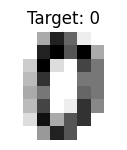

In [6]:
digits = load_digits()
images = digits.images
y = digits.target

for i in range(1):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation="nearest")
    plt.title(f"Target: {y[i]}")
    plt.axis("off")

In [11]:
def images_to_graphs(images: np.ndarray) -> List[grakel.Graph]:
    num_images, height, width = images.shape

    graphs = []
    edges = []
    edge_labels = {}
    for row_idx in range(height):
        for col_idx in range(width):
            if col_idx < width - 1:
                edge = (row_idx * height + col_idx, row_idx * height + col_idx + 1)
                edges.append(edge)
                edge_labels[edge] = 1

            if row_idx < height - 1:
                edge = (row_idx * height + col_idx, (row_idx + 1) * height + col_idx)

                edges.append(edge)
                edge_labels[edge] = 2
    G = nx.Graph(edges)
    nx.draw_networkx(G)

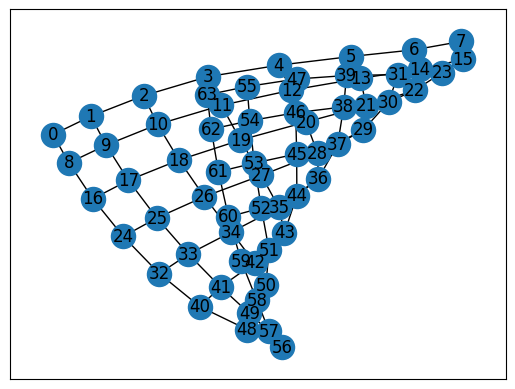

In [14]:
images_to_graphs(images)

# Graph Classification using Shortest Path Kernel and SVM

In [15]:
from __future__ import print_function
print(__doc__)

import numpy as np
import os

from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from grakel.datasets import fetch_dataset
from grakel.kernels import ShortestPath

Automatically created module for IPython interactive environment


In [16]:
dataset_metadata = {
    "AIDS": {"nl": True, "el": True, "na": True, "ea": False,
             "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
             "morris/graphkerneldatasets/AIDS.zip"},
    "BZR": {"nl": True, "el": False, "na": True, "ea": False,
            "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
            "morris/graphkerneldatasets/BZR.zip"},
    "BZR_MD": {"nl": True, "el": True, "na": False, "ea": True,
               "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
               "morris/graphkerneldatasets/BZR_MD.zip"},
    "COIL-DEL": {"nl": False, "el": True, "na": True, "ea": False,
                 "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/" +
                 "graphkerneldatasets/COIL-DEL.zip"},
    "COIL-RAG": {"nl": False, "el": False, "na": True, "ea": True,
                 "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/" +
                 "graphkerneldatasets/COIL-RAG.zip"},
    "COLLAB": {"nl": False, "el": False, "na": False, "ea": False,
               "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/" +
               "graphkerneldatasets/COLLAB.zip"},
    "COX2": {"nl": True, "el": False, "na": True, "ea": False,
             "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/" +
             "graphkerneldatasets/COX2.zip"},
    "COX2_MD": {"nl": True, "el": True, "na": False, "ea": True,
                "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/" +
                "graphkerneldatasets/COX2_MD.zip"},
    "DHFR": {"nl": True, "el": False, "na": True, "ea": False,
             "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/" +
             "graphkerneldatasets/DHFR.zip"},
    "DHFR_MD": {"nl": True, "el": True, "na": False, "ea": True,
                "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/" +
                "graphkerneldatasets/DHFR_MD.zip"},
    "ER_MD": {"nl": True, "el": True, "na": False, "ea": True,
              "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/" +
              "graphkerneldatasets/ER_MD.zip"},
    "DD": {"nl": True, "el": False, "na": False, "ea": False,
           "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/" +
           "graphkerneldatasets/DD.zip"},
    "ENZYMES": {"nl": True, "el": False, "na": True, "ea": False,
                "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/" +
                "graphkerneldatasets/ENZYMES.zip"},
    "Cuneiform": {"nl": True, "el": True, "na": True, "ea": True,
                  "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/"
                          "graphkerneldatasets/Cuneiform.zip"},
    "FINGERPRINT": {"nl": False, "el": False, "na": True, "ea": True,
                    "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                    "morris/graphkerneldatasets/Fingerprint.zip"},
    "FIRSTMM_DB": {"nl": True, "el": False, "na": True, "ea": True,
                   "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                   "morris/graphkerneldatasets/FIRSTMM_DB.zip"},
    "FRANKENSTEIN": {"nl": False, "el": False, "na": True, "ea": False,
                     "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
                     "ris/graphkerneldatasets/FRANKENSTEIN.zip"},
    "IMDB-BINARY": {"nl": False, "el": False, "na": False, "ea": False,
                    "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
                    "ris/graphkerneldatasets/IMDB-BINARY.zip"},
    "IMDB-MULTI": {"nl": False, "el": False, "na": False, "ea": False,
                   "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                   "morris/graphkerneldatasets/IMDB-MULTI.zip"},
    "Letter-high": {"nl": False, "el": False, "na": True, "ea": False,
                    "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
                    "ris/graphkerneldatasets/Letter-high.zip"},
    "Letter-low": {"nl": False, "el": False, "na": True, "ea": False,
                   "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
                   "ris/graphkerneldatasets/Letter-low.zip"},
    "Letter-med": {"nl": False, "el": False, "na": True, "ea": False,
                   "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
                   "ris/graphkerneldatasets/Letter-med.zip"},
    "Mutagenicity": {"nl": True, "el": True, "na": False, "ea": False,
                     "link": "https://ls11-www.cs.uni-dortmund.de/peo" +
                     "ple/morris/graphkerneldatasets/Mutagenicity.zip"},
    "MSRC_9": {"nl": True, "el": False, "na": False, "ea": False,
               "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/" +
               "graphkerneldatasets/MSRC_9.zip"},
    "MSRC_21": {"nl": True, "el": False, "na": False, "ea": False,
                "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
                "ris/graphkerneldatasets/MSRC_21.zip"},
    "MSRC_21C": {"nl": True, "el": False, "na": False, "ea": False,
                 "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
                 "ris/graphkerneldatasets/MSRC_21C.zip"},
    "MUTAG": {"nl": True, "el": True, "na": False, "ea": False,
              "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
              "ris/graphkerneldatasets/MUTAG.zip"},
    "NCI1": {"nl": True, "el": False, "na": False, "ea": False,
             "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
             "ris/graphkerneldatasets/NCI1.zip"},
    "NCI109": {"nl": True, "el": False, "na": False, "ea": False,
               "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
               "ris/graphkerneldatasets/NCI109.zip"},
    "PTC_FM": {"nl": True, "el": True, "na": False, "ea": False,
               "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
               "ris/graphkerneldatasets/PTC_FM.zip"},
    "PTC_FR": {"nl": True, "el": True, "na": False, "ea": False,
               "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
               "ris/graphkerneldatasets/PTC_FR.zip"},
    "PTC_MM": {"nl": True, "el": True, "na": False, "ea": False,
               "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
               "ris/graphkerneldatasets/PTC_MM.zip"},
    "PTC_MR": {"nl": True, "el": True, "na": False, "ea": False,
               "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
               "ris/graphkerneldatasets/PTC_MR.zip"},
    "PROTEINS": {"nl": True, "el": False, "na": True, "ea": False,
                 "link": "https://ls11-www.cs.uni-dortmund.de/people/mor" +
                 "ris/graphkerneldatasets/PROTEINS.zip"},
    "PROTEINS_full": {"nl": True, "el": False, "na": True, "ea": False,
                      "link": "https://ls11-www.cs.uni-dortmund.de/people" +
                      "/morris/graphkerneldatasets/PROTEINS_full.zip"},
    "REDDIT-BINARY": {"nl": False, "el": False, "na": False, "ea": False,
                      "link": "https://ls11-www.cs.uni-dortmund.de/people" +
                      "/morris/graphkerneldatasets/REDDIT-BINARY.zip"},
    "REDDIT-MULTI-5K": {"nl": False, "el": False, "na": False, "ea": False,
                        "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                        "morris/graphkerneldatasets/REDDIT-MULTI-5K.zip"},
    "REDDIT-MULTI-12K": {"nl": False, "el": False, "na": False, "ea": False,
                         "link": "https://ls11-www.cs.uni-dortmund.de/peop" +
                         "le/morris/graphkerneldatasets/REDDIT-MULTI-12K.zip"},
    "SYNTHETIC": {"nl": False, "el": False, "na": True, "ea": False,
                  "link": "https://ls11-www.cs.uni-dortmund.de/people" +
                  "/morris/graphkerneldatasets/SYNTHETIC.zip"},
    "SYNTHETICnew": {"nl": False, "el": False, "na": True, "ea": False,
                     "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                     "morris/graphkerneldatasets/SYNTHETICnew.zip"},
    "Synthie": {"nl": False, "el": False, "na": True, "ea": False,
                "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                "morris/graphkerneldatasets/Synthie.zip"},
    "Tox21_AHR": {"nl": True, "el": True, "na": False, "ea": False,
                  "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                  "morris/graphkerneldatasets/Tox21_AHR.zip"},
    "Tox21_AR": {"nl": True, "el": True, "na": False, "ea": False,
                 "link": "https://ls11-www.cs.uni-dortmund.de/people/morris/" +
                 "graphkerneldatasets/COX2_MD.zip"},
    "Tox21_AR-LBD": {"nl": True, "el": True, "na": False, "ea": False,
                     "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                     "morris/graphkerneldatasets/Tox21_AR-LBD.zip"},
    "Tox21_ARE": {"nl": True, "el": True, "na": False, "ea": False,
                  "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                  "morris/graphkerneldatasets/Tox21_ARE.zip"},
    "Tox21_aromatase": {"nl": True, "el": True, "na": False, "ea": False,
                        "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                        "morris/graphkerneldatasets/Tox21_aromatase.zip"},
    "Tox21_ATAD5": {"nl": True, "el": True, "na": False, "ea": False,
                    "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                    "morris/graphkerneldatasets/Tox21_ATAD5.zip"},
    "Tox21_ER": {"nl": True, "el": True, "na": False, "ea": False,
                 "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                 "morris/graphkerneldatasets/Tox21_ER.zip"},
    "Tox21_ER_LBD": {"nl": True, "el": True, "na": False, "ea": False,
                     "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                     "morris/graphkerneldatasets/Tox21_ER_LBD.zipp"},
    "Tox21_HSE": {"nl": True, "el": True, "na": False, "ea": False,
                  "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                  "morris/graphkerneldatasets/Tox21_HSE.zip"},
    "Tox21_MMP": {"nl": True, "el": True, "na": False, "ea": False,
                  "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                  "morris/graphkerneldatasets/Tox21_MMP.zip"},
    "Tox21_p53": {"nl": True, "el": True, "na": False, "ea": False,
                  "link": "https://ls11-www.cs.uni-dortmund.de/people/" +
                  "morris/graphkerneldatasets/Tox21_p53.zip"},
    "Tox21_PPAR-gamma": {"nl": True, "el": True, "na": False, "ea": False,
                         "link": "https://ls11-www.cs.uni-dortmund.de/peop" +
                         "le/morris/graphkerneldatasets/Tox21_PPAR-gamma.zip"}
}

# Function to read molecules data

In [17]:
def read_data(
        name,
        with_classes=True,
        prefer_attr_nodes=False,
        prefer_attr_edges=False,
        produce_labels_nodes=False,
        as_graphs=False,
        is_symmetric=False):
    indicator_path = "./data/"+str(name)+"/"+str(name)+"_graph_indicator.txt"
    edges_path = "./data/" + str(name) + "/" + str(name) + "_A.txt"
    node_labels_path = "./data/" + str(name) + "/" + str(name) + "_node_labels.txt"
    node_attributes_path = "./data/"+str(name)+"/"+str(name)+"_node_attributes.txt"
    edge_labels_path = "./data/" + str(name) + "/" + str(name) + "_edge_labels.txt"
    edge_attributes_path = \
        "./data/" + str(name) + "/" + str(name) + "_edge_attributes.txt"
    graph_classes_path = \
        "./data/" + str(name) + "/" + str(name) + "_graph_labels.txt"

    # node graph correspondence
    ngc = dict()
    # edge line correspondence
    elc = dict()
    # dictionary that keeps sets of edges
    Graphs = dict()
    # dictionary of labels for nodes
    node_labels = dict()
    # dictionary of labels for edges
    edge_labels = dict()

    # Associate graphs nodes with indexes
    with open(indicator_path, "r") as f:
        for (i, line) in enumerate(f, 1):
            ngc[i] = int(line[:-1])
            if int(line[:-1]) not in Graphs:
                Graphs[int(line[:-1])] = set()
            if int(line[:-1]) not in node_labels:
                node_labels[int(line[:-1])] = dict()
            if int(line[:-1]) not in edge_labels:
                edge_labels[int(line[:-1])] = dict()

    # Extract graph edges
    with open(edges_path, "r") as f:
        for (i, line) in enumerate(f, 1):
            edge = line[:-1].replace(' ', '').split(",")
            elc[i] = (int(edge[0]), int(edge[1]))
            Graphs[ngc[int(edge[0])]].add((int(edge[0]), int(edge[1])))
            if is_symmetric:
                Graphs[ngc[int(edge[1])]].add((int(edge[1]), int(edge[0])))

    # Extract node attributes
    if (prefer_attr_nodes and
        dataset_metadata[name].get(
                "na",
                os.path.exists(node_attributes_path)
                )):
        with open(node_attributes_path, "r") as f:
            for (i, line) in enumerate(f, 1):
                node_labels[ngc[i]][i] = \
                    [float(num) for num in
                     line[:-1].replace(' ', '').split(",")]
    # Extract node labels
    elif dataset_metadata[name].get(
            "nl",
            os.path.exists(node_labels_path)
            ):
        with open(node_labels_path, "r") as f:
            for (i, line) in enumerate(f, 1):
                node_labels[ngc[i]][i] = int(line[:-1])
    elif produce_labels_nodes:
        for i in range(1, len(Graphs)+1):
            node_labels[i] = dict(Counter(s for (s, d) in Graphs[i] if s != d))

    # Extract edge attributes
    if (prefer_attr_edges and
        dataset_metadata[name].get(
            "ea",
            os.path.exists(edge_attributes_path)
            )):
        with open(edge_attributes_path, "r") as f:
            for (i, line) in enumerate(f, 1):
                attrs = [float(num)
                         for num in line[:-1].replace(' ', '').split(",")]
                edge_labels[ngc[elc[i][0]]][elc[i]] = attrs
                if is_symmetric:
                    edge_labels[ngc[elc[i][1]]][(elc[i][1], elc[i][0])] = attrs

    # Extract edge labels
    elif dataset_metadata[name].get(
            "el",
            os.path.exists(edge_labels_path)
            ):
        with open(edge_labels_path, "r") as f:
            for (i, line) in enumerate(f, 1):
                edge_labels[ngc[elc[i][0]]][elc[i]] = int(line[:-1])
                if is_symmetric:
                    edge_labels[ngc[elc[i][1]]][(elc[i][1], elc[i][0])] = \
                        int(line[:-1])

    Gs = list()
    if as_graphs:
        for i in range(1, len(Graphs)+1):
            Gs.append(Graph(Graphs[i], node_labels[i], edge_labels[i]))
    else:
        for i in range(1, len(Graphs)+1):
            Gs.append([Graphs[i], node_labels[i], edge_labels[i]])

    if with_classes:
        classes = []
        with open(graph_classes_path, "r") as f:
            for line in f:
                classes.append(int(line[:-1]))

        classes = np.array(classes, dtype=np.intc)
        return Bunch(data=Gs, target=classes)
    else:
        return Bunch(data=Gs)

In [18]:
# Loads the MUTAG dataset
MUTAG = read_data("MUTAG",
                  with_classes=True,
                  prefer_attr_nodes=False,
                  prefer_attr_edges=False,
                  produce_labels_nodes=False,
                  is_symmetric=False,
                  as_graphs=False)
G, y = MUTAG.data, MUTAG.target

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)

In [19]:
print(len(G_train), len(G_test), len(y_train), len(y_test))

169 19 169 19


## Shortest path kernel and SVM

Accuracy is metrics to predict

In [20]:
# Uses the shortest path kernel to generate the kernel matrices
gk = ShortestPath(normalize=True)
K_train = gk.fit_transform(G_train)
K_test = gk.transform(G_test)

# Uses the SVM classifier to perform classification
clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", str(round(acc*100, 2)) + "%")

Accuracy: 94.74%


### Visualize with TSNE

In [32]:
from sklearn.manifold import TSNE

# Visualize using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(K_train)

169
169
188


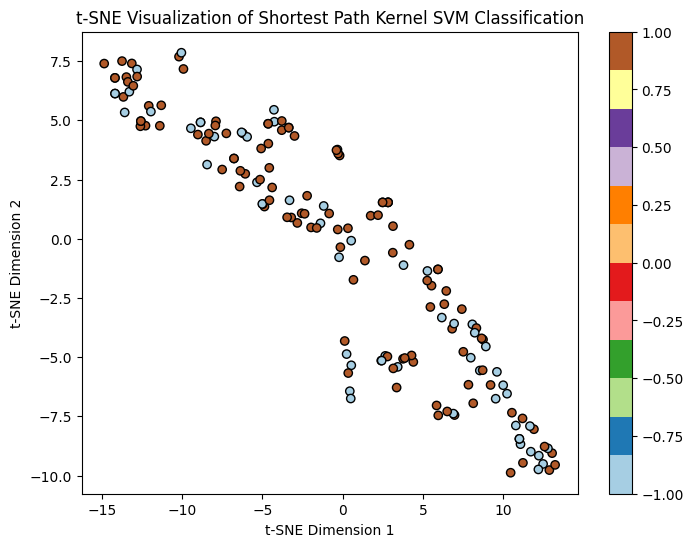

In [31]:
# Check the lengths of the arrays
print(len(X_embedded[:, 0]))
print(len(X_embedded[:, 1]))
print(len(y))

# If the lengths are not equal, adjust the length of the c argument
if len(X_embedded[:, 0]) != len(y):
    y = y[:len(X_embedded[:, 0])]

# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=plt.cm.Paired, edgecolor='k')
plt.title('t-SNE Visualization of Shortest Path Kernel SVM Classification')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()